<a href="https://colab.research.google.com/github/estel1/it6/blob/master/Copy_of_firdesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель работы**: расчет цифрового фильтра с конечной импульсной характеристикой нижних частот методом частотной выборки с применением оконного взвешивания импульсной характеристики.

Т.е. необходимо определить коэффициенты фильтра $h_m$ по заданному частотному отклику:
\begin{equation}
y_{k}=\sum\limits_{m=0}^{M-1}h_mx_{k-m} \tag{1}
\end{equation}

**План расчета:**


*   Сформировать массив значений для желаемого частотного отклика $H_k$, массив содержит значения 1 для тех частотных точек где фильтр должен пропускать сигнал и значения 0 для частотных точек в которых сигнал должен подавляться (это и есть т.н. частотная выборка). Длина массива $H_k$ определяет качество аппроксимации фильтра и не связана с длиной входного сигнала! При формировании массива $H_k$ следует учитывать, что звук (полезный сигнал) располагается преимущественно в низких частотах, а шум сосредоточен в верхних частотах (в данном конкретном примере). Также не забываем, что спектр дискретного сигнала - это периодическая функция, заполняем один период от 0 до $M-1$, где $M$-длина фильтра, $M-1$ - последняя точка периода частотной характеристики.
*   Задавшись задержкой в фильтре равной половине его длины (если в фильтре нет задержки он не может быть физически реализован, другими словами невозможно получить результат фильтрации мгновенно) получить фазовую часть частотного отклика (в случае задержки на половину длины надо умножить частотную характеристику на $\pm1$, т.е. $Hk*\cos(\pi k)$)
*   С помощью процедуры дискретного обратного преобразования Фурье получить оценку импульсного отклика фильтра $h_n=\frac{1}{M}\sum_{k=0}^{M-1}H_ke^{\frac{2\pi}{M}nk}$. Проверить, что импульсная характеристика не содержит комплексных значений (мнимая часть не превышает машинную точность $\epsilon=10^{-16}$ для вычислений в формате double). Построить частотный отклик с уменьшенным шагом по частоте и обнаружить эффект Гиббса. Умножить импульсную характеристику поточечно на окно Хэмминга. Вновь построить частотный отклик с уменьшенным шагом по частоте, проверить выбросы вблизи частоты среза. Сделать выводы об эффективности метода оконного взвешивания в части подавления эффекта Гиббса.
*   С помощью полученной импульсной характеристики осуществить фильтрацию зашумленного сигнала со звуком. 
*   Построить спектр звукового сигнала на входе и выходе фильтра. Построить амплитудно-частотную характеристику фильтра. Построить фазовую характеристику фильтра. Прослушать звук на выходе фильтра. Сравнить качесвто звучания до и после селективной фильтрации.




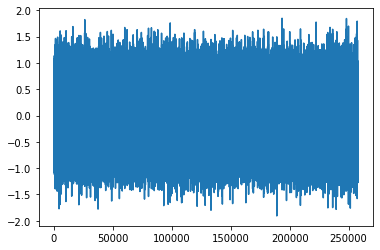

In [2]:
# загрузка файла со звуком
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from IPython.display import Audio

x = np.loadtxt("https://raw.githubusercontent.com/RF-Lab/lab_sources/master/x.txt")

Audio(x,rate=32000)


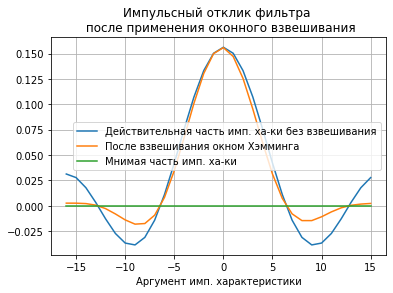

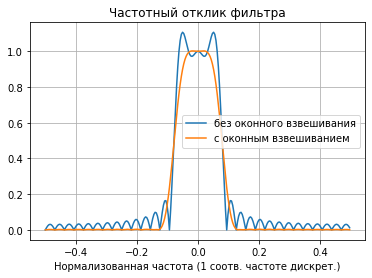

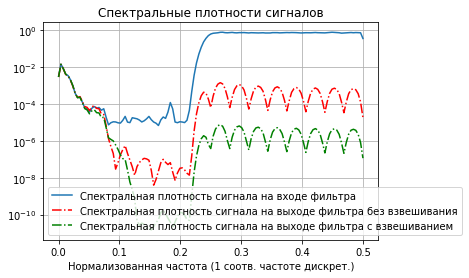

In [10]:
# Расчет фильтра с импульсной характеристикой конечной длины (КИХ)
# методом частотной выборки с применением оконного взвешивания
# импульсного отклика
# (С) Институт Комплексной Безопасности и Специального Приборостроения (МГУПИ)
# Кафедра КБ-3 "Управление и моделирование систем"

M = 64//2  # Filter length
C = 6//2   # cutoff frequency index
# Define LP frequency response
H = np.zeros( (M,), dtype=complex )
H[0:C] = 1.0 ;
H[-C+1:] = 1.0 ;
H = H*np.cos(np.pi*np.arange(0.,M))
h = np.fft.ifft(H)

# Apply Hamming window
hw = h*np.hamming(M)

fig = plt.figure()
plt.plot(np.arange(0.,M)-M/2,np.real(h))
plt.plot(np.arange(0.,M)-M/2,np.real(hw))
plt.plot(np.arange(0.,M)-M/2,np.imag(hw))
plt.grid('true')
plt.legend(['Действительная часть имп. ха-ки без взвешивания','После взвешивания окном Хэмминга','Мнимая часть имп. ха-ки'])
plt.xlabel('Аргумент имп. характеристики')
plt.title('Импульсный отклик фильтра \n после применения оконного взвешивания')

Hp          = np.fft.fftshift(np.fft.fft(h,256))
Hpw         = np.fft.fftshift(np.fft.fft(hw,256))
fig2        = plt.figure()
plt.plot(np.arange(-.5,.5,.5/128),np.abs(Hp))
plt.plot(np.arange(-.5,.5,.5/128),np.abs(Hpw))
plt.grid('true')
plt.legend(['без оконного взвешивания','с оконным взвешиванием'])
plt.xlabel('Нормализованная частота (1 соотв. частоте дискрет.)')
plt.title('Частотный отклик фильтра')

hflt  = np.real(h)
y     = np.convolve( hflt, x, 'same' )

hflt  = np.real(hw)
yw    = np.convolve( hflt, x, 'same' )

frex,Pxx     = signal.welch( x )
frey,Pyy     = signal.welch( y )
frew,Pyw     = signal.welch( yw )
fig2        = plt.figure()
plt.semilogy( frex,Pxx )
plt.semilogy( frey,Pyy, 'r-.' )
plt.semilogy( frew,Pyw, 'g-.' )
plt.legend(['Спектральная плотность сигнала на входе фильтра','Спектральная плотность сигнала на выходе фильтра без взвешивания','Спектральная плотность сигнала на выходе фильтра с взвешиванием'])
plt.xlabel('Нормализованная частота (1 соотв. частоте дискрет.)')
plt.title('Спектральные плотности сигналов')
plt.grid('true')

Audio(yw,rate=32000)


Text(0, 0.5, 'Амплитуда')

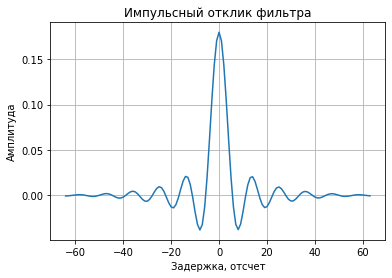

In [8]:

plt.plot(np.arange(0.,M)-M/2,hflt)
plt.title('Импульсный отклик фильтра')
plt.grid(True)
plt.xlabel('Задержка, отсчет')
plt.ylabel('Амплитуда')



$X_k=\sum\limits_{n=0}^{N-1}x_n e^{-i\frac{2\pi}{N}kn}$ X=np.fft.fft(x,len(X)*2)

$X(\omega)=\sum\limits_{n=0}^{N-1}x_n e^{-i\omega n}$ $X(\omega)$=signal.freqz( b=x )

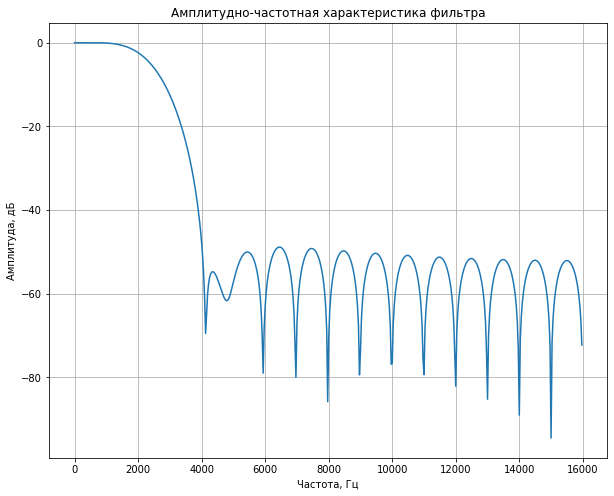

In [11]:
plt.figure(figsize=(10,8))
w, h = signal.freqz(hflt,whole=False,fs=32000)
_=plt.plot( w, 20*np.log10( np.abs(h)) )
plt.grid(True)
plt.xlabel('Частота, Гц')
plt.ylabel('Амплитуда, дБ')
plt.title('Амплитудно-частотная характеристика фильтра')
plt.show()

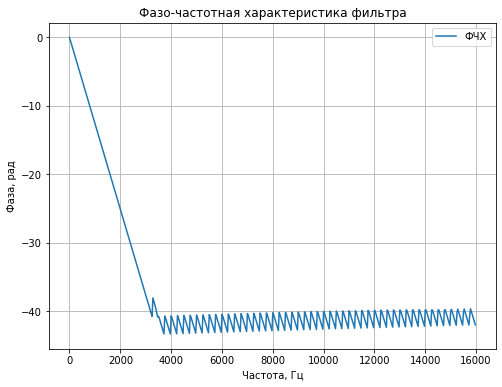

In [ ]:
plt.figure(figsize=(8,6))
w, h = signal.freqz(hflt,whole=False,fs=32000)
_=plt.plot( w, np.unwrap(np.angle(h)), label='ФЧХ' )
plt.grid(True)
plt.xlabel('Частота, Гц')
plt.ylabel('Фаза, рад')
plt.title('Фазо-частотная характеристика фильтра')
plt.legend()
plt.show()

No handles with labels found to put in legend.


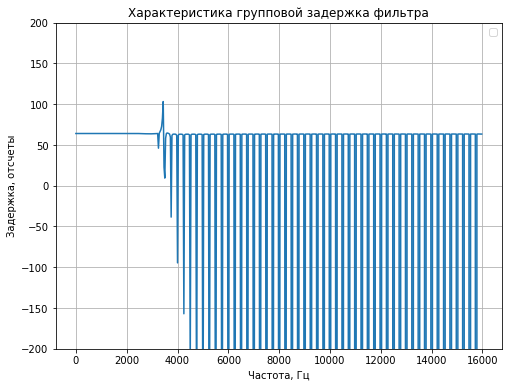

In [ ]:
from scipy import signal
w, gd = signal.group_delay((hflt, 1),fs=32000)
plt.figure(figsize=(8,6))
plt.plot( w,gd )
plt.ylim([-200,200])

plt.grid(True)
plt.xlabel('Частота, Гц')
plt.ylabel('Задержка, отсчеты')
plt.title('Характеристика групповой задержка фильтра')
plt.legend()
plt.show()


$H_k=\sum\limits_{n=0}^{N-1}h_ne^{-i\frac{2\pi}{N}kn}$

$H_k=e^{i\frac{2\pi}{N}km}H_k$



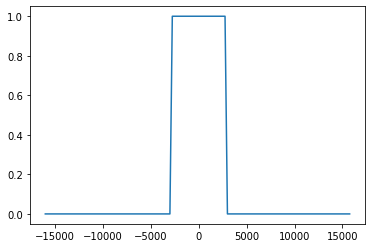

In [7]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(len(H)))*32000, np.fft.fftshift(np.abs(H)))